# Simulation of production line with defects


In this notebook we will train a Anomalib model using the Anomalib API and our own dataset. This notebook is also part of the Dobot series notebooks.

### Use case

Using the [Dobot Magician](https://www.dobot.cc/dobot-magician/product-overview.html) we could simulate a production line system. Imagine we have a cubes factory and they need to know when a defect piece appear in the process. We know very well what is the aspecto of the normal cubes. Defects are coming no often and we need to put those defect cubes out of the production line.

<img src="https://user-images.githubusercontent.com/10940214/174126337-b344bbdc-6343-4d85-93e8-0cb1bf39a4e3.png" alt="drawing" style="width:400px;"/>

| Class    | Yellow cube                                                                                                                                           | Red cube                                                                                                                                              | Green cube                                                                                                                                            | Inferencing using Anomalib                                                                                                                            |
| -------- | ----------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------- |
| Normal   | <img src="https://user-images.githubusercontent.com/10940214/174083561-38eec918-efc2-4ceb-99b1-bbb4c91396b2.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083638-85ff889c-6222-4428-9c7d-9ad62bd15afe.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083707-364177d4-373b-4891-96ce-3e5ea923e440.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174129305-03d9b71c-dfd9-492f-b42e-01c5c24171cc.jpg" alt="drawing" style="width:150px;"/> |
| Abnormal | <img src="https://user-images.githubusercontent.com/10940214/174083805-df0a0b03-58c7-4ba8-af50-fd94d3a13e58.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083873-22699523-22b4-4a55-a3da-6520095af8af.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083944-38d5a6f4-f647-455b-ba4e-69482dfa3562.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174129253-f7a567d0-84f7-4050-8065-f00ba8bb973d.jpg" alt="drawing" style="width:150px;"/> |

Using Anomalib we are expecting to see this result.


# Installing Anomalib

The easiest way to install anomalib is to use pip. You can install it from the command line using the following command:


In [1]:
%pip install anomalib[full]

## Imports


In [2]:
"""501a_training_a_model_with_cubes_from_a_robotic_arm.ipynb."""

from pathlib import Path

from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer

## Download dataset and Robot API/Driver

We should prepare the folder to save the dataset and the Dobot API and drivers. To download the dataset and the Dobot API and drivers we will use anomalib's `download_and_extract` utility function.


In [3]:
from anomalib.data.utils import DownloadInfo, download_and_extract

dataset_download_info = DownloadInfo(
    name="cubes.zip",
    url="https://github.com/openvinotoolkit/anomalib/releases/download/dobot/cubes.zip",
    checksum="e6e067f9e0979a4d190dd2cb1db227d7",
)
api_download_info = DownloadInfo(
    name="dobot_api.zip",
    url="https://github.com/openvinotoolkit/anomalib/releases/download/dobot/dobot_api.zip",
    checksum="89d6d6400cdff03de3c25d2c54f2b443",
)
download_and_extract(root=Path.cwd(), info=dataset_download_info)
download_and_extract(root=Path.cwd(), info=api_download_info)

cubes.zip: 6.99MB [00:02, 2.85MB/s]                            
dobot_api.zip: 3.69MB [00:01, 1.99MB/s]                            


### Dataset: Cubes

Prepare your own dataset for normal and defect pieces.


In [4]:
from anomalib.data import Folder
from anomalib import TaskType

datamodule = Folder(
    root=Path.cwd() / "cubes",
    normal_dir="normal",
    abnormal_dir="abnormal",
    normal_split_ratio=0.2,
    image_size=(256, 256),
    train_batch_size=32,
    eval_batch_size=32,
    task=TaskType.CLASSIFICATION,
)
datamodule.setup()  # Split the data to train/val/test/prediction sets.
datamodule.prepare_data()  # Create train/val/test/predic dataloaders

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

dict_keys(['image_path', 'label', 'image'])


In [5]:
# Check image size
print(data["image"].shape)

torch.Size([32, 3, 256, 256])


## Model

`anomalib` supports a wide range of unsupervised anomaly detection models. The table in this [link](https://anomalib.readthedocs.io/en/latest/markdown/guides/reference/models/image/index.html) shows the list of models currently supported by `anomalib` library.


### Prepare the Model

We will use Padim model for this use case, which could be imported from `anomalib.models`.


In [6]:
from anomalib.models import Padim

model = Padim(
    input_size=(256, 256),
    backbone="resnet18",
    layers=["layer1", "layer2", "layer3"],
)

## Training

Now that we set up the datamodule and model, we could now train the model.

The final component to train the model is `Engine` object, which handles train/test/predict/export pipeline. Let's create the engine object to train the model.


In [7]:
from anomalib.engine import Engine
from anomalib.utils.normalization import NormalizationMethod

engine = Engine(
    normalization=NormalizationMethod.MIN_MAX,
    threshold="F1AdaptiveThreshold",
    task=TaskType.CLASSIFICATION,
    image_metrics=["AUROC"],
    accelerator="auto",
    check_val_every_n_epoch=1,
    devices=1,
    max_epochs=1,
    num_sanity_val_steps=0,
    val_check_interval=1.0,
)

engine.fit(model=model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/abogusze/repos/anomalib/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/home/abogusze/repos/anomalib/venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. 

Training: |          | 0/? [00:00<?, ?it/s]

/home/abogusze/repos/anomalib/venv/lib/python3.10/site-packages/lightning/pytorch/loops/optimization/automatic.py:129: `training_step` returned `None`. If this was on purpose, ignore this warning...


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [8]:
# Validation
test_results = engine.test(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
└───────────────────────────┴───────────────────────────┘

In [9]:
from anomalib.deploy import ExportType

# Exporting model to OpenVINO
openvino_model_path = engine.export(
    model=model,
    export_type=ExportType.OPENVINO,
    datamodule=datamodule,
    export_root=str(Path.cwd()),
    input_size=(256, 256),
)

/home/abogusze/repos/anomalib/venv/lib/python3.10/site-packages/torch/onnx/_internal/jit_utils.py:307: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/home/abogusze/repos/anomalib/venv/lib/python3.10/site-packages/torch/onnx/utils.py:702: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/home/abogusze/repos/anomalib/venv/lib/python3.10/site-packages/torch/onnx/utils.py:1209: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit

## OpenVINO Inference

Now that we trained and tested a model, we could check a single inference result using OpenVINO inferencer object. This will demonstrate how a trained model could be used for inference.


### Load a Test Image

Let's read an image from the test set and perform inference using OpenVINO inferencer.


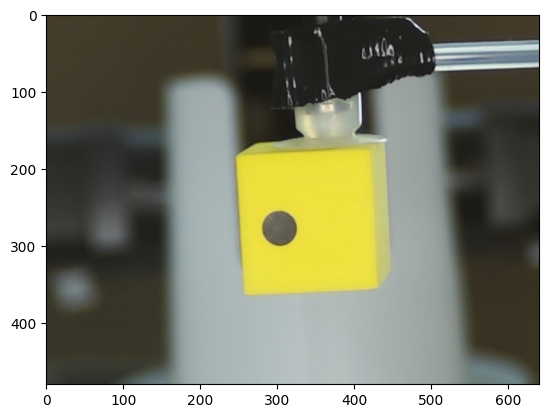

In [10]:
from matplotlib import pyplot as plt

image_path = "./cubes/abnormal/input_20230210134059.jpg"
image = read_image(path="./cubes/abnormal/input_20230210134059.jpg")
plt.imshow(image)

### Load the OpenVINO Model

By default, the output files are saved into `results` directory. Let's check where the OpenVINO model is stored.


In [11]:
metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

True True


In [12]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  # We would like to run it on an Intel CPU.
)

### Perform Inference

Predicting an image using OpenVINO inferencer is as simple as calling `predict` method.


In [13]:
print(image.shape)
predictions = inferencer.predict(image=image)

(480, 640, 3)


where `predictions` contain any relevant information regarding the task type. For example, predictions for a segmentation model could contain image, anomaly maps, predicted scores, labels or masks.

### Visualizing Inference Results

`anomalib` provides a number of tools to visualize the inference results. Let's visualize the inference results using the `Visualizer` method.


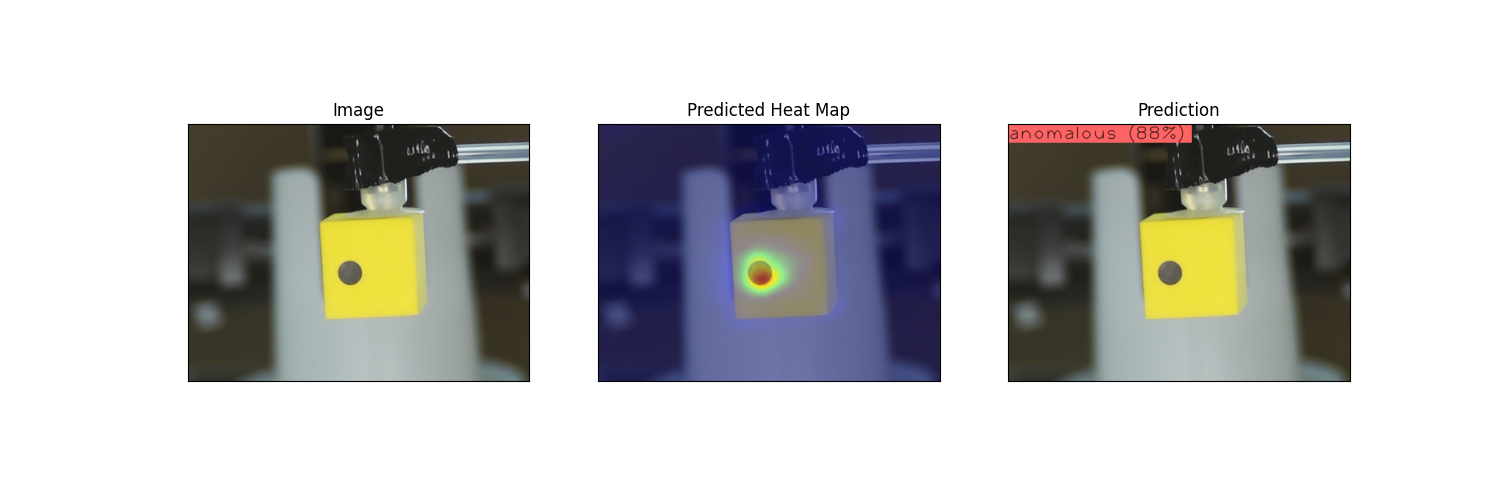

In [14]:
from anomalib.utils.visualization import Visualizer, VisualizationMode
from PIL import Image

visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)

Since `predictions` contain a number of information, we could specify which information we want to visualize. For example, if we want to visualize the predicted mask and the segmentation results, we could specify the task type as `TaskType.SEGMENTATION`, which would produce the following visualization.


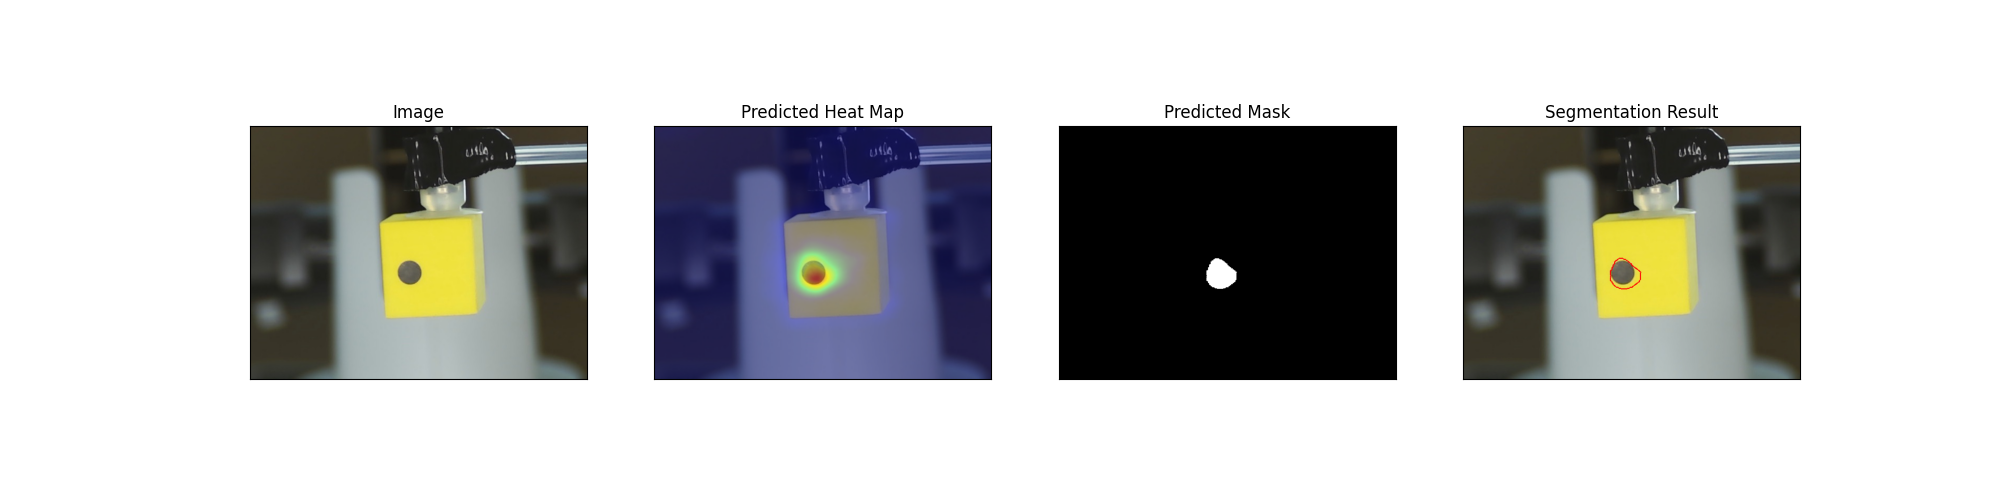

In [15]:
visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.SEGMENTATION)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)